In [1]:
import os
import numpy as np
from skimage import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt
from skimage import io, transform
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

# Set your paths to the dataset here.
IMAGE_PATH = '/Users/blood-vessel-segmentation/train/images'
LABEL_PATH = '/Users/blood-vessel-segmentation/train/labels'

In [2]:
# Custom function to preprocess images
def preprocess_image(image, max_pixel_value=255.0):
    # Normalize images by max pixel value to keep the range [0, 1]
    img = transform.resize(image, target_resolution, mode='constant', anti_aliasing=True)
    img = img.astype('float32') / max_pixel_value
    return img

# Custom function to preprocess masks
def preprocess_mask(mask):
    # Use nearest-neighbor interpolation to prevent artifacts
    mask = transform.resize(mask, target_resolution, order=0, mode='constant', preserve_range=True)
    mask = mask.astype('float32') / 255.0
    mask = mask > 0.5  # Binarize the mask
    return mask

# Ensure that image and mask file names are sorted in the same way
image_files = sorted([f for f in os.listdir(IMAGE_PATH) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(LABEL_PATH) if f.endswith('.tif')])

# Verify that each image file corresponds to its mask file by comparing filenames
for img_file, lbl_file in zip(image_files, label_files):
    assert os.path.splitext(img_file)[0] == os.path.splitext(lbl_file)[0], f"Mismatch found: {img_file} and {lbl_file}"

# Load images and labels
images = [io.imread(os.path.join(IMAGE_PATH, file)) for file in image_files]
labels = [io.imread(os.path.join(LABEL_PATH, file)) for file in label_files]

# Downscale the images to a lower resolution to save on memory (e.g., 128x128).
target_resolution = (128, 128)
images = np.array([transform.resize(img, target_resolution, mode='constant', preserve_range=True) for img in images])
labels = np.array([transform.resize(lbl, target_resolution, mode='constant', preserve_range=True) for lbl in labels])

# Apply the custom preprocessing to your images and masks
preprocessed_images = [preprocess_image(img) for img in images]
preprocessed_labels = [preprocess_mask(lbl) for lbl in labels]

In [3]:
# Calculate vessel densities for each mask
vessel_densities = [np.sum(mask) / np.prod(mask.shape) for mask in preprocessed_labels]

# Define the bins for stratification, e.g., using quartiles
density_bins = np.quantile(vessel_densities, q=[0, .25, .5, .75, 1])

# Categorize each mask into one of the bins
density_strata = np.digitize(vessel_densities, density_bins)

# Now split the data into training and validation sets, stratified by density_strata
X_train, X_val, y_train, y_val = train_test_split(
    preprocessed_images, preprocessed_labels,
    test_size=0.2, random_state=42, stratify=density_strata
)

# Add the batch dimension to your data
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

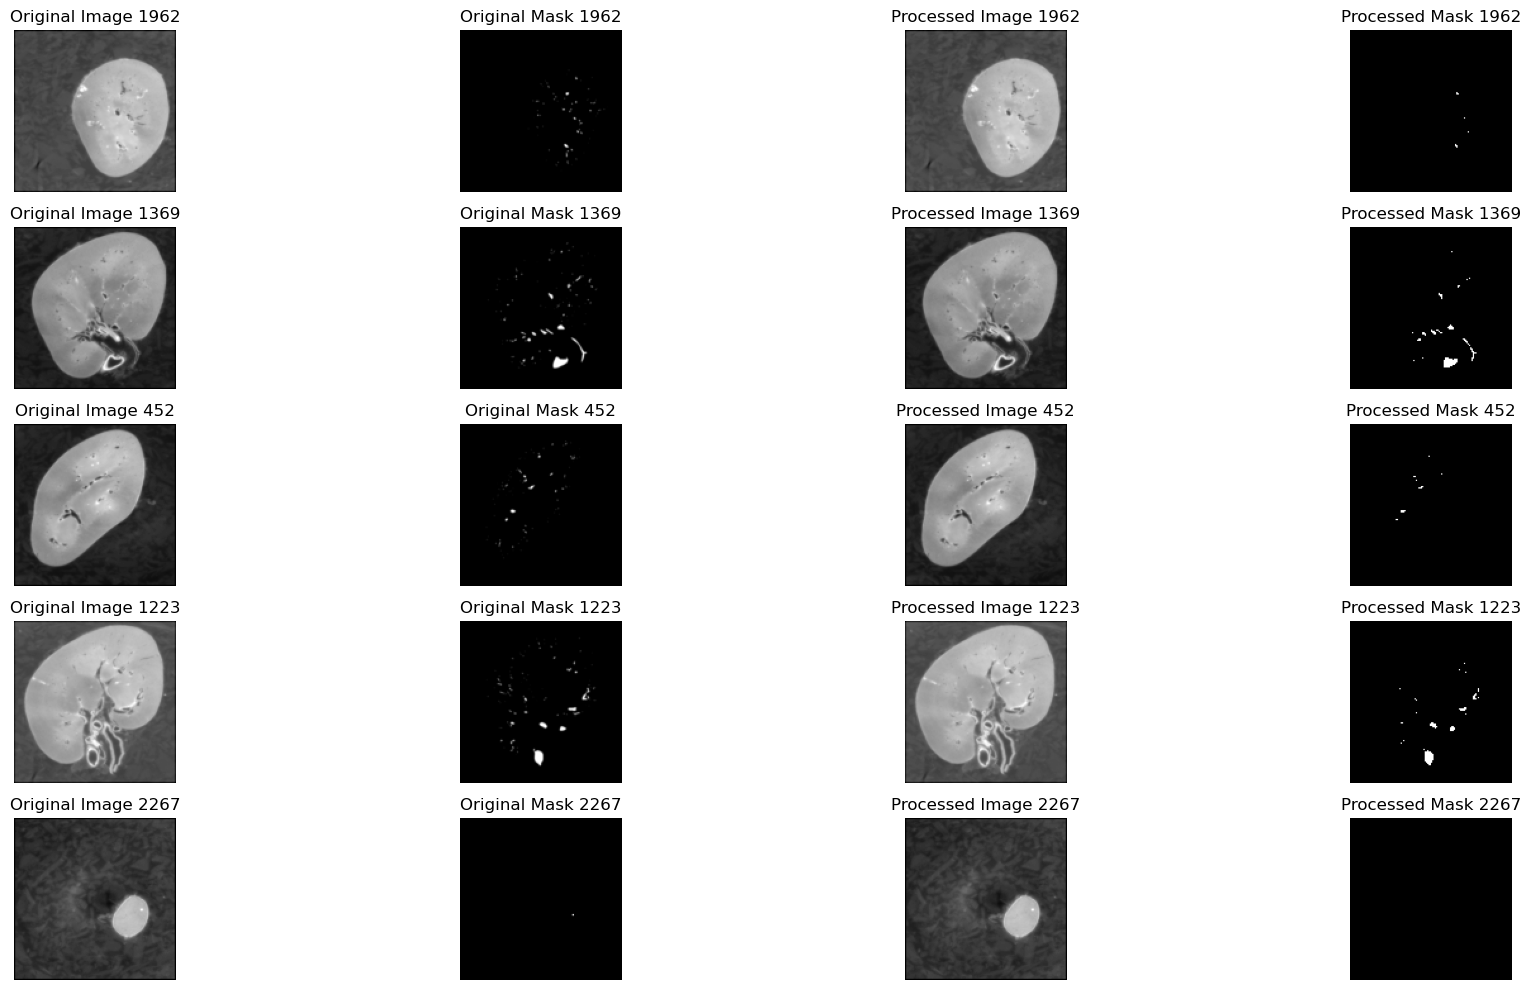

In [4]:
import matplotlib.pyplot as plt

def visualize_data_integrity(original_images, processed_images, original_masks, processed_masks, num_samples=5):
    assert len(original_images) == len(processed_images) == len(original_masks) == len(processed_masks)
    indices = np.random.choice(range(len(original_images)), num_samples, replace=False)
    
    plt.figure(figsize=(20, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 4, 4*i + 1)
        plt.imshow(original_images[idx], cmap='gray')
        plt.title(f'Original Image {idx}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, 4*i + 2)
        plt.imshow(original_masks[idx], cmap='gray')
        plt.title(f'Original Mask {idx}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, 4*i + 3)
        plt.imshow(processed_images[idx], cmap='gray')
        plt.title(f'Processed Image {idx}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, 4*i + 4)
        plt.imshow(processed_masks[idx], cmap='gray')
        plt.title(f'Processed Mask {idx}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Use this function after you have preprocessed your images and masks
visualize_data_integrity(images, preprocessed_images, labels, preprocessed_labels)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Dropout

def get_unet_model(input_shape):
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.1)(pool1)  # Dropout after pooling layer
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.1)(pool2)  # Similar dropout after second pooling layer
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3)  # Increased dropout rate for the third pooling layer
    
    # Bottom of the U-Net
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.3)(conv4)

    # Up-sampling path
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Final layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coefficient])
    
    return model

# Adjust the input shape to match the downsampled image size.
model = get_unet_model((128, 128, 1))

2023-12-20 22:56:14.140440: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-20 22:56:14.140484: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-20 22:56:14.140497: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-20 22:56:14.140554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 22:56:14.140579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Train the model with a smaller batch size.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,  # Smaller batch size
    epochs=30,  # Fewer epochs to reduce training time
    verbose=1
)

Epoch 1/30


2023-12-20 22:56:15.249987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - ETA: 0s - loss: 0.4014 - dice_coefficient: 0.0187

2023-12-20 22:56:32.430581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - 19s 77ms/step - loss: 0.4014 - dice_coefficient: 0.0187 - val_loss: 0.1250 - val_dice_coefficient: 0.0213
Epoch 2/30
228/228 [==============================] - 17s 74ms/step - loss: 0.0706 - dice_coefficient: 0.0947 - val_loss: 0.0314 - val_dice_coefficient: 0.1532
Epoch 3/30
228/228 [==============================] - 17s 73ms/step - loss: 0.0224 - dice_coefficient: 0.2448 - val_loss: 0.0161 - val_dice_coefficient: 0.3300
Epoch 4/30
228/228 [==============================] - 17s 73ms/step - loss: 0.0114 - dice_coefficient: 0.3998 - val_loss: 0.0091 - val_dice_coefficient: 0.4575
Epoch 5/30
228/228 [==============================] - 16s 72ms/step - loss: 0.0072 - dice_coefficient: 0.5281 - val_loss: 0.0061 - val_dice_coefficient: 0.5701
Epoch 6/30
228/228 [==============================] - 17s 72ms/step - loss: 0.0052 - dice_coefficient: 0.6151 - val_loss: 0.0043 - val_dice_coefficient: 0.6664
Epoch 7/30
228/228 [==============================]

15/15 [==============================] - 1s 50ms/step


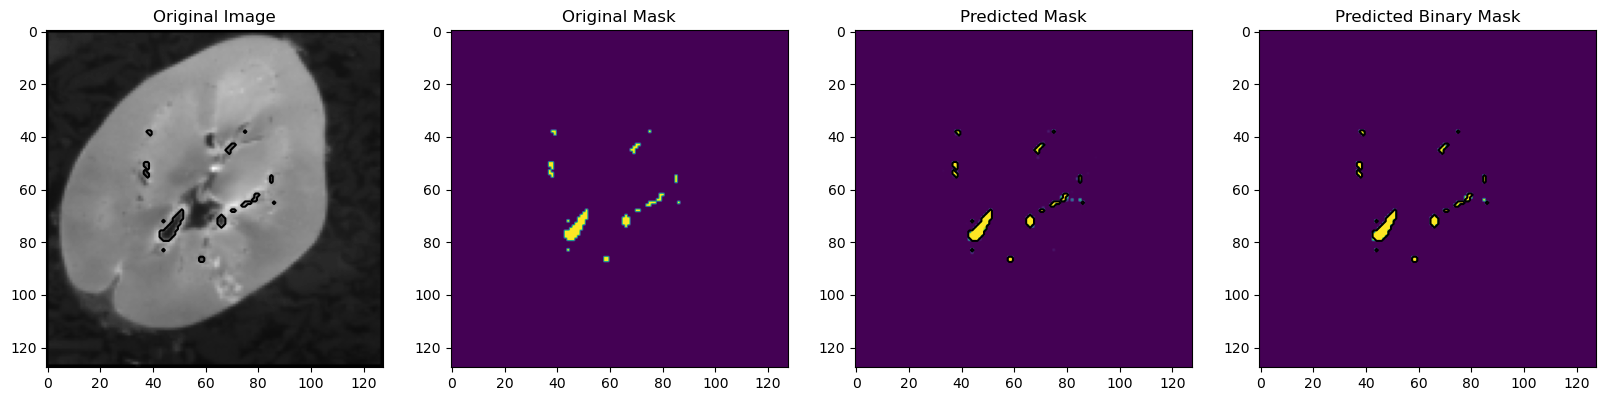

In [11]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Original Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary Mask')

# Predict on train, val and test
preds_val = model.predict(X_val, verbose=1)
# Threshold predictions
binary_preds_val = (preds_val > 0.5).astype(np.uint8)

# Plotting a random sample
plot_sample(X_val, y_val, preds_val, binary_preds_val)

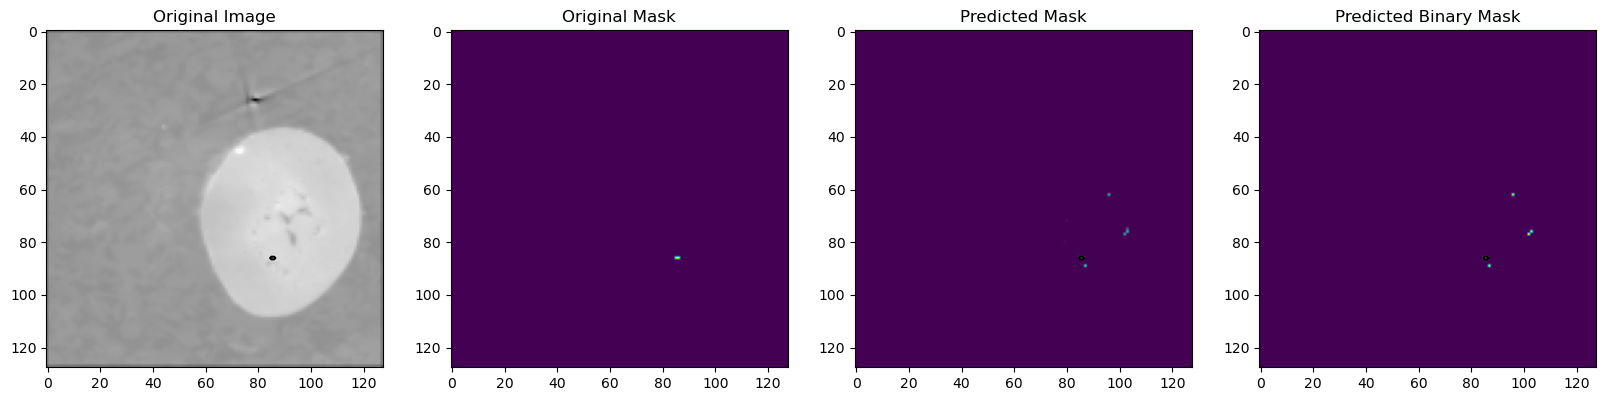

In [10]:
def worst_performing_indices(y_true, y_pred):
    dice_scores = [dice_coefficient(y_true[i].astype(np.float32), y_pred[i].astype(np.float32)).numpy() 
                   for i in range(len(y_true))]
    return np.argsort(dice_scores)

# Now try finding the worst performing indices on the validation set again
worst_indices = worst_performing_indices(y_val, binary_preds_val)

# And plot the worst-performing images
plot_sample(X_val, y_val, preds_val, binary_preds_val, ix=worst_indices[0])

In [9]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Convert predictions and ground truths to float32 for calculation
val_dice_scores = [dice_coefficient(y_val[i].astype(np.float32), preds_val[i].astype(np.float32)).numpy()
                   for i in range(len(y_val))]

# Calculate the average Dice score across all validation samples
average_val_dice_score = np.mean(val_dice_scores)

print(f'Average Validation Dice Score: {average_val_dice_score}')

Average Validation Dice Score: 0.7992511987686157
